In [0]:
from google.colab import drive
drive.mount('/content/drive')

#Deep Learning Project (CNN with fractional_max for MNIST)
---
###Running the Experiment on Google Colab
This notebook is running remotely on the Google Colab Platform, therefore to save and access the trained model and checkpoints in your local computer you need to mount the Google Drive. Specify the path to your project directory.





In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive/'
path = '/content/gdrive/My Drive/CS4240_Project/' #set the path as your own location
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive  CS4240_Project  D2L  RQ


###Import Required Libraries and Datasets

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import matplotlib
from matplotlib import pyplot as plt
import datetime
from torchsummary import summary
import numpy as np
%load_ext tensorboard

Download the MNIST dataset using `torchvision.datasets`.



torch.Size([1, 28, 28])
class: 2


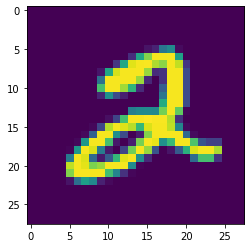

In [0]:
data_path = path + 'data/'
save_path = path + 'model/'
MNIST_train = datasets.MNIST(data_path, train = True, download = False, transform = transforms.ToTensor())
MNIST_test = datasets.MNIST(data_path, train = False, download = False, transform = transforms.ToTensor())
img, _ = MNIST_train[5]
print(img.shape)
plt.imshow(img[0])
print('class:', _)

Use `torch.utils.data.DataLoader` to assign batch and apply shuffle to data.


In [0]:
#load data as batches
train_loader = torch.utils.data.DataLoader(MNIST_train,
                                            batch_size = 64,
                                            shuffle = True)
val_loader = torch.utils.data.DataLoader(MNIST_test,
                                            batch_size = 64,
                                            shuffle = False)

###Build the Convolutional Neural Network


Fractional MaxPooling 6 layers:

In [0]:
class Net_Fmax(nn.Module):
  def __init__(self):
    super(Net_Fmax, self).__init__()
    self.conv1 = nn.Conv2d(1,   32,  kernel_size=2, padding=4)
    self.conv2 = nn.Conv2d(32,  64,  kernel_size=2, padding=0)
    self.conv3 = nn.Conv2d(64,  96,  kernel_size=2, padding=0)
    self.conv4 = nn.Conv2d(96,  128, kernel_size=2, padding=0)
    self.conv5 = nn.Conv2d(128, 160, kernel_size=2, padding=0)
    self.conv6 = nn.Conv2d(160, 192, kernel_size=2, padding=0)
    self.conv7 = nn.Conv2d(192, 192, kernel_size=2, padding=0)
    self.frac_maxpool = nn.FractionalMaxPool2d(kernel_size = 2, output_ratio = (0.72,0.72))
    self.fc = nn.Linear(192, 10)

  def forward(self, x):
    out = F.relu(self.frac_maxpool(self.conv1(x)))
    out = F.relu(self.frac_maxpool(self.conv2(out)))
    out = F.relu(self.frac_maxpool(self.conv3(out)))
    out = F.relu(self.frac_maxpool(self.conv4(out)))
    out = F.relu(self.frac_maxpool(self.conv5(out)))
    out = F.relu(self.frac_maxpool(self.conv6(out)))
    out = F.relu(self.conv7(out))
    out = out.view(-1, 192)
    out = self.fc(out)
    return out
summary(Net_Fmax().cuda(), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 35, 35]             160
FractionalMaxPool2d-2           [-1, 32, 25, 25]               0
            Conv2d-3           [-1, 64, 24, 24]           8,256
FractionalMaxPool2d-4           [-1, 64, 17, 17]               0
            Conv2d-5           [-1, 96, 16, 16]          24,672
FractionalMaxPool2d-6           [-1, 96, 11, 11]               0
            Conv2d-7          [-1, 128, 10, 10]          49,280
FractionalMaxPool2d-8            [-1, 128, 7, 7]               0
            Conv2d-9            [-1, 160, 6, 6]          82,080
FractionalMaxPool2d-10            [-1, 160, 4, 4]               0
           Conv2d-11            [-1, 192, 3, 3]         123,072
FractionalMaxPool2d-12            [-1, 192, 2, 2]               0
           Conv2d-13            [-1, 192, 1, 1]         147,648
           Linear-14           

###Design Training Loop

In [0]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs_Fmax')

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    max_accuracy = 0
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
          outputs = model(imgs.cuda())
          labels = labels.cuda()
          loss = loss_fn(outputs, labels)
          optimizer.zero_grad() #for gradient accumulation
          loss.backward()
          optimizer.step()
          loss_train += loss.item() #for visualization 
          writer.add_scalar('train_loss', loss.item(), epoch)
        
        #tensorboard write, for every 10 epochs, print train loss
        if epoch == 1 or epoch % 15 == 0:
            with torch.no_grad():
              total = 0
              correct = 0

              for imgs_val, labels_val in val_loader:
                imgs_val = imgs_val.cuda()
                labels_val = labels_val.cuda()
                outputs_val = model.eval()(imgs_val)
                _, index_max = torch.max(outputs_val, dim = 1)
                total += labels_val.shape[0]  #val_loader has no attribute shape
                correct += (index_max == labels_val).sum().item()
              accuracy = float(correct / total)

              if accuracy >= max_accuracy:
                max_accuracy = accuracy

            print('{} Epoch {:3}, Training Loss {:2.6f}, Max Test Accuracy {:2.6f}'.format(datetime.datetime.now(), epoch, float(loss_train), float(max_accuracy)))
            writer.add_scalar('test_accuracy', accuracy, epoch)

    print('Finished Training')
    writer.close()
    return max_accuracy

###Run optimization (SGD Momentum) 
To use **GPU** acceleration, we need to make sure our model is running in GPU mode, which only accept `torch.cuda.FloatTensor` as inputs.

In [0]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('CUDA is available:', torch.cuda.is_available())
learning_rate = 1e-2

CUDA is available: True


Set up random number generator (RNG)

In [0]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True

Remember `NLLLoss = -sum(log(output_i[c_i])` where the `sum` is taken over $n$ samples and $c_i$ is the correct class for sample $i$.

In [0]:
number_of_tests = 4
max_accuracy = [] #12 trainings and tests
for seed in range(number_of_tests):
  setup_seed(1)
  model = Net_Fmax().cuda()
  optimizer = optim.SGD(params = model.parameters(), lr = learning_rate, momentum = 0.9)  #be careful with the calculation chain!
  test_accuracy = training_loop(n_epochs = 2000,
                        optimizer = optimizer,
                        model = model.train(),
                        loss_fn = nn.CrossEntropyLoss(),  #equivalent to LogSoftmax & NLLLoss
                        train_loader = train_loader)
  max_accuracy.append(test_accuracy)
  print("Best test accuracy:\n", max_accuracy)  #Expect: 0.34 test error

2020-03-23 14:20:54.146808 Epoch   1, Training Loss 2016.909211, Max Test Accuracy 0.756000
2020-03-23 14:23:32.634577 Epoch  15, Training Loss 21.432168, Max Test Accuracy 0.991600
2020-03-23 14:26:22.112137 Epoch  30, Training Loss 10.156166, Max Test Accuracy 0.992500
2020-03-23 14:29:11.763951 Epoch  45, Training Loss 7.539145, Max Test Accuracy 0.994200
2020-03-23 14:32:03.271766 Epoch  60, Training Loss 5.632886, Max Test Accuracy 0.994700
2020-03-23 14:34:54.912676 Epoch  75, Training Loss 3.174332, Max Test Accuracy 0.994700
2020-03-23 14:37:46.061911 Epoch  90, Training Loss 2.682190, Max Test Accuracy 0.994700
2020-03-23 14:40:37.318198 Epoch 105, Training Loss 1.929618, Max Test Accuracy 0.994700
2020-03-23 14:43:28.316905 Epoch 120, Training Loss 3.508312, Max Test Accuracy 0.994700
2020-03-23 14:46:18.919544 Epoch 135, Training Loss 1.687135, Max Test Accuracy 0.994700
2020-03-23 14:49:12.358630 Epoch 150, Training Loss 1.719820, Max Test Accuracy 0.994700
2020-03-23 14:52

We can use tensorboard to visualize more vividly of out training process.

In [0]:
%tensorboard --logdir runs_Fmax/